In [1]:
import limbo
from limbo.processing import CALGAIN
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import glob
import os
import ipynbname

%matplotlib inline
# %matplotlib notebook

%load_ext memory_profiler

In [2]:
# pspec_file = os.environ['LIMBO_PSPEC_FILE']
pspec_file = '/Users/darbymccauley/research/frbs/limbo_data/data/spectral/Spectra_20230613095040.dat'
SUB = -6

# VOLT_DIR = os.environ.get('LIMBO_VOLT_DIR', None)
VOLT_DIR = '/Users/darbymccauley/research/frbs/limbo_data/data/voltage/'
VOLT_SAVE_DIR = os.environ.get('LIMBO_VOLT_SAVE_DIR', None)
VOLT_REMOVE_DIR = os.environ.get('LIMBO_VOLT_REMOVE_DIR', None)

VOLT_PREFIX = 'VoltageV2_'
f = os.path.basename(pspec_file[:SUB] + '*')
volt_files = sorted(glob.glob(os.path.join(VOLT_DIR, VOLT_PREFIX + f.split('_')[-1])))

PAD = 2000
RESAMP_FACTOR = 4
CH0, CH1 = 398, 398+1024
NSIG = 5.5

print('Processing candidate from', os.path.basename(pspec_file) + ':\n')
print('Processing Voltage Files:', [os.path.basename(file) for file in volt_files])

Processing candidate from Spectra_20230613095040.dat:

Processing Voltage Files: ['VoltageV2_20230613095036.dat', 'VoltageV2_20230613095037.dat', 'VoltageV2_20230613095038.dat', 'VoltageV2_20230613095039.dat', 'VoltageV2_20230613095040.dat', 'VoltageV2_20230613095041.dat']


In [3]:
vhdr = limbo.io.read_volt_header(volt_files[0])
vhdr

{'SWVer': '0.0.4',
 'fpg': 'limbo_500_m_2023-05-09_1203.fpg',
 'Time': 1686649836.203594,
 'AccLen': 1,
 'AdcCoarseGain': 4,
 'FFTShift': 2047,
 'DataSel': 1,
 'Scaling': 0,
 'Pol0EqCoeff': 59904,
 'Pol1EqCoeff': 59904,
 'SpecCoeff': 4,
 'AdcDelay0': 5,
 'AdcDelay1': 5,
 'AdcDelay2': 5,
 'AdcDelay3': 5,
 'AdcDelay4': 5,
 'AdcDelay5': 5,
 'AdcDelay6': 5,
 'AdcDelay7': 5,
 'RF_Lo_Hz': 1350000000,
 'Source': 'sgr1935',
 'Target_RA_Deg': '19h34m55.598s',
 'Target_DEC_Deg': '+21d53m47.79s',
 'Pointing_AZ': 157.3,
 'Pointing_EL': 72.92,
 'Pointing_Updated': 1686649831.688087,
 'filename': '/Users/darbymccauley/research/frbs/limbo_data/data/voltage/VoltageV2_20230613095036.dat',
 'sample_clock': 500000000.0,
 'freqs': array([1.35000000e+09, 1.35012207e+09, 1.35024414e+09, ...,
        1.59963379e+09, 1.59975586e+09, 1.59987793e+09]),
 'Time_created': 1686649836.302161,
 'filesize': 489392132,
 'data_start': 2052,
 'inttime': 8.192e-06,
 'nspec': 118784}

In [4]:
# Reprocess pspec file
hdr, data = limbo.io.read_file(pspec_file)

if hdr['Source'] == 'sgr1935':
    DM = 332.7
    k = (300, 400)
    MAX_DM = 300
elif hdr['Source'] == 'crab':
    DM = 56.7
    k = (40, 60)
    MAX_DM = 30
    
dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM, 
                                    inpaint=True, ch0=CH0, ch1=CH1, do_dmt=True)

cal_data = dmt['diff'] * CALGAIN
delays = limbo.sim.DM_delay(DM, hdr['freqs']).astype('float32')
delays -= delays[-1]  # center lowest delay at t0
profile = limbo.utils.dedisperse(cal_data, DM, hdr['freqs'], hdr['inttime'], RESAMP_FACTOR)

freq_binned_profile = np.mean(profile[:, CH0:CH1].reshape(profile.shape[0], -1, 256), axis=-1)
avg_profile = np.mean(profile[:, CH0:CH1], axis=-1)
zscore = (avg_profile - np.mean(avg_profile)) / np.std(avg_profile)

tind_events = np.where((zscore > NSIG))[0]

_dts = np.linspace(hdr['times'][0], hdr['times'][-1], profile.shape[0], endpoint=False) # Unix time
# zeroed_dts = _dts - hdr['Time']

In [5]:
# Now process voltage files
vp = limbo.processing.ProcessVoltage(DM=DM)

t_events = _dts[tind_events]
data_real, data_imag = vp.find_volt_window(volt_files, t_events, vhdr, PAD)
vdata = vp.sum_pols(data_real, data_imag)

vdmt = limbo.processing.process_data(vhdr, vdata, ch0=CH0, ch1=CH1, gsig=4, do_dmt=False)
vcal_data = vdmt['diff'] * CALGAIN * np.sqrt(hdr['inttime'] / vhdr['inttime'])

SUM_INT = 128
vdata_summed = vp.sum_down(vcal_data, sum_int=SUM_INT)

vdelays = limbo.sim.DM_delay(DM, vhdr['freqs']).astype('float32')
vdelays -= vdelays[-1] # center lowest delay at t0
vprofile = limbo.utils.dedisperse(vdata_summed, DM, vhdr['freqs'], SUM_INT * vhdr['inttime'], RESAMP_FACTOR)

In [6]:
%memit

peak memory: 1446.59 MiB, increment: 0.11 MiB


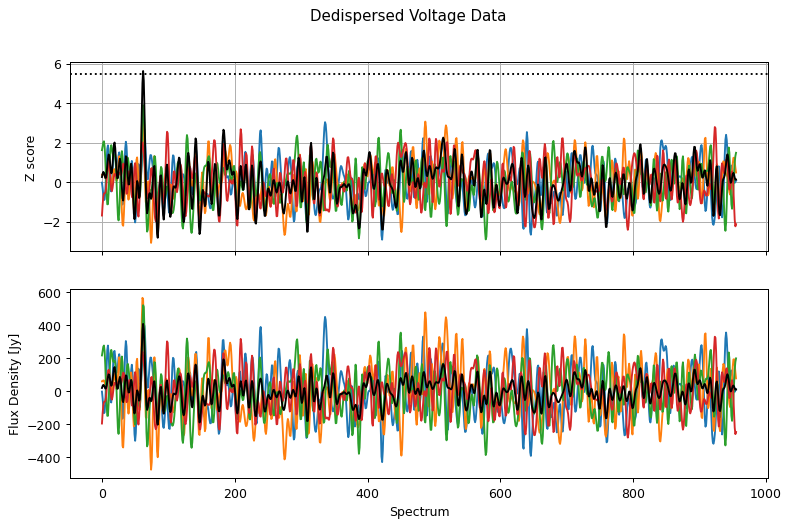

In [7]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
freq_binned_vprofile = np.mean(vprofile[:, CH0:CH1].reshape(vprofile.shape[0], -1, 256), axis=-1)
avg_vprofile = np.mean(vprofile[:, CH0:CH1], axis=-1)
vzscore = (avg_vprofile - np.mean(avg_vprofile)) / np.std(avg_vprofile)
axes[0].plot((freq_binned_vprofile - np.mean(freq_binned_vprofile, axis=0, keepdims=True)) / np.std(freq_binned_vprofile, axis=0, keepdims=True))
axes[0].plot((avg_vprofile - np.mean(avg_vprofile)) / np.std(avg_vprofile), 'k')
axes[0].axhline(NSIG, color='k', ls=':')
axes[1].plot(freq_binned_vprofile)
axes[1].plot(avg_vprofile, 'k')
#     axes[1].set_xlabel('Time [s]')
axes[1].set_xlabel('Spectrum')
axes[0].set_ylabel('Z score')
axes[0].grid()
axes[1].set_ylabel('Flux Density [Jy]')
fig.suptitle('Dedispersed Voltage Data')
plt.show()

In [11]:
recovered = False
events = np.where(vzscore > NSIG)[0]
if events.size > 0:
    print('Candidate FRB recovered.')
    zmax = np.max(vzscore[events])
    print(f'De-dispersed Z-score: {zmax:4.1f}')
    recovered = True
    
print(f'Recovered: {recovered}')

Candidate FRB recovered.
De-dispersed Z-score:  5.6
Recovered: True


In [9]:
nb_name = ipynbname.name()+'.ipynb'

if recovered:
    if VOLT_SAVE_DIR != None:
        outfile = os.path.join(VOLT_SAVE_DIR, nb_name)
        print(f'Moving {nb_name} --> {outfile}')
        os.rename(nb_name, outfile)
else:
    if VOLT_REMOVE_DIR != None:
        outfile = os.path.join(VOLT_REMOVE_DIR, nb_name)
        print(f'Moving {nb_name} --> {outfile}')
        os.rename(nb_name, outfile)